## Business Context

Megaline is a telecommunications company that offers two prepaid plans: Surf and Ultimate.
The commercial team aims to understand which plan generates higher revenue in order to optimize marketing investments and advertising strategy.

This analysis is based on a sample of 500 customers and includes information about customer profiles, usage behavior (calls, messages, and internet traffic), and plan subscriptions throughout 2018.

## Objective

The objective of this project is to analyze customer behavior and revenue patterns associated with each prepaid plan, and to determine whether there is a statistically significant difference in the average revenue generated by Surf and Ultimate customers.

The results of this analysis are intended to support data-driven decision-making regarding budget allocation and plan positioning.

## Analytical Approach

This project follows an iterative data analysis workflow, starting with data loading and preprocessing, followed by feature aggregation, exploratory analysis, and statistical hypothesis testing.

Each step builds on the previous one to ensure data consistency, interpretability, and reliable conclusions aligned with the business objective.

## Environment Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Data Loading

In [2]:
# Load datasets
megaline_calls = pd.read_csv('../data/megaline_calls.csv')
megaline_internet = pd.read_csv('../data/megaline_internet.csv')
megaline_messages = pd.read_csv('../data/megaline_messages.csv')
megaline_plans = pd.read_csv('../data/megaline_plans.csv')
megaline_users = pd.read_csv('../data/megaline_users.csv')

## Data Preparation

Before proceeding with the analysis, the datasets are explored individually to understand their structure, data types, and potential quality issues.  
This step includes inspecting each table, identifying inconsistencies, and applying necessary corrections to ensure reliable analysis in subsequent stages.

## Plans Overview

In [3]:
megaline_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
megaline_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The plans dataset contains two rows, representing the two prepaid plans offered by Megaline: Surf and Ultimate.  
All columns have appropriate data types, and no missing values were identified.

The sample confirms consistency with the business logic: the higher-priced plan includes larger allowances and lower overage fees, while the lower-priced plan has stricter limits and higher marginal costs.

No data quality issues were detected in this table, and no further preprocessing is required at this stage.

## Users Overview

In [5]:
megaline_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
megaline_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


The users dataset contains 500 records and 8 columns.  
Most columns have appropriate data types, with the exception of the registration and churn date fields (`reg_date` and `churn_date`), which are stored as object types and should be converted to datetime format.

Missing values are present in the `churn_date` column, which is expected since these entries correspond to customers who had not canceled their plans at the time of data extraction.  
No additional data quality issues were identified at this stage.

### Data Type Corrections

In [7]:
megaline_users["reg_date"] = pd.to_datetime(megaline_users["reg_date"])
megaline_users["churn_date"] = pd.to_datetime(megaline_users["churn_date"])

## Calls Overview

In [8]:
megaline_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [9]:
megaline_calls.sample(5, random_state=42)

,id,user_id,call_date,duration
52288,1187_481,1187,2018-12-12,0.00
30634,1114_568,1114,2018-10-21,1.05
54228,1196_106,1196,2018-07-23,5.67
110372,1389_454,1389,2018-05-12,11.49
109600,1386_60,1386,2018-11-24,0.00


The calls dataset contains 137,735 records and 4 columns.  
The `call_date` column is stored as an object type and should be converted to datetime to enable time-based analysis.

The remaining columns have appropriate data types. The `duration` field is numeric and represents call duration, potentially including fractional values, which should be considered in later aggregations and revenue calculations.

No missing values or additional data quality issues were identified at this stage.

### Data Type Corrections

In [10]:
megaline_calls["call_date"] = pd.to_datetime(megaline_calls["call_date"])

### Feature Engineering

In [11]:
megaline_calls["month"] = megaline_calls["call_date"].dt.to_period("M")

## Messages Overview

In [12]:
megaline_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [13]:
megaline_messages.sample(5, random_state=42)

,id,user_id,message_date
58331,1369_132,1369,2018-12-27
24196,1145_51,1145,2018-07-11
9284,1069_42,1069,2018-12-03
44214,1293_1181,1293,2018-10-06
57006,1362_72,1362,2018-05-25


The messages dataset contains 76,051 records and 3 columns.  
The `message_date` column is stored as an object type and should be converted to datetime format to support time-based aggregations.

All other columns have appropriate data types, and no missing values were identified.  
Each row represents an individual message, which enables aggregation by user and by time period in later stages of the analysis.

### Data Type Corrections

In [14]:
megaline_messages["message_date"] = pd.to_datetime(megaline_messages["message_date"])

### Feature Engineering

In [15]:
megaline_messages["month"] = megaline_messages["message_date"].dt.to_period("M")

## Internet Usage Overview

In [16]:
megaline_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [17]:
megaline_internet.sample(5, random_state=42)

,id,user_id,session_date,mb_used
102423,1490_238,1490,2018-10-15,373.01
12472,1060_181,1060,2018-09-14,875.38
91959,1426_53,1426,2018-12-29,627.48
42208,1187_385,1187,2018-09-20,132.80
64201,1294_122,1294,2018-10-29,397.70


The internet usage dataset contains 104,825 records and 4 columns.  
The `session_date` column is stored as an object type and should be converted to datetime to enable time-based analysis.

All remaining columns have appropriate data types, and no missing values were identified.  
The `mb_used` column represents data consumption per session and includes zero-value entries, which may indicate sessions without actual traffic and should be considered during subsequent analysis.

### Data Type Corrections

In [18]:
megaline_internet["session_date"] = pd.to_datetime(megaline_internet["session_date"])

### Feature Engineering

In [19]:
megaline_internet["month"] = megaline_internet["session_date"].dt.to_period("M")

## Plan Conditions and Pricing Structure

Before calculating customer revenue, it is necessary to review the pricing structure and usage limits of each plan.  
This step ensures that overage charges and monthly fees are applied correctly in subsequent revenue calculations.

In [20]:
display(megaline_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Monthly Usage Aggregation and Revenue Calculation

To compare plan performance, usage data is aggregated at the customer-month level.  
This unified monthly table is then combined with plan rules (allowances and overage fees) to compute monthly revenue per user.

In [21]:
# Monthly calls: number of calls and total duration (minutes)
calls_monthly = (
    megaline_calls
    .groupby(["user_id", "month"])
    .agg(
        call_count=("id", "count"),
        total_call_duration=("duration", "sum")
    )
    .reset_index()
)

# Monthly messages: number of messages
messages_monthly = (
    megaline_messages
    .groupby(["user_id", "month"])
    .size()
    .reset_index(name="message_count")
)

# Monthly internet usage: total MB used
internet_monthly = (
    megaline_internet
    .groupby(["user_id", "month"])
    .agg(total_mb_used=("mb_used", "sum"))
    .reset_index()
)

# Combine monthly usage into a single table
monthly_usage = (
    calls_monthly
    .merge(messages_monthly, on=["user_id", "month"], how="outer")
    .merge(internet_monthly, on=["user_id", "month"], how="outer")
)

monthly_usage = monthly_usage.fillna(0)

monthly_usage = monthly_usage.merge(
    megaline_users[["user_id", "plan"]],
    on="user_id",
    how="left"
)

monthly_usage = monthly_usage.merge(
    megaline_plans,
    left_on="plan",
    right_on="plan_name",
    how="left"
)

monthly_usage.head()

,user_id,month,call_count,total_call_duration,message_count,total_mb_used,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,2018-12,16.0,116.83,11.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1001,2018-08,27.0,171.14,30.0,6919.15,surf,50,15360,500,20,10,0.03,0.03,surf
2,1001,2018-09,49.0,297.69,44.0,13314.82,surf,50,15360,500,20,10,0.03,0.03,surf
3,1001,2018-10,65.0,374.11,53.0,22330.49,surf,50,15360,500,20,10,0.03,0.03,surf
4,1001,2018-11,64.0,404.59,36.0,18504.30,surf,50,15360,500,20,10,0.03,0.03,surf


In [22]:
# Overage minutes
monthly_usage["extra_minutes"] = (
    monthly_usage["total_call_duration"] - monthly_usage["minutes_included"]
).clip(lower=0)
monthly_usage["extra_minutes_cost"] = (
    monthly_usage["extra_minutes"] * monthly_usage["usd_per_minute"]
)

# Overage messages
monthly_usage["extra_messages"] = (
    monthly_usage["message_count"] - monthly_usage["messages_included"]
).clip(lower=0)
monthly_usage["extra_messages_cost"] = (
    monthly_usage["extra_messages"] * monthly_usage["usd_per_message"]
)

# Overage internet: billed per GB (rounded up)
monthly_usage["gb_used"] = np.ceil(monthly_usage["total_mb_used"] / 1024)
monthly_usage["extra_gb"] = (
    monthly_usage["gb_used"] - (monthly_usage["mb_per_month_included"] / 1024)
).clip(lower=0)
monthly_usage["extra_gb_cost"] = (
    monthly_usage["extra_gb"] * monthly_usage["usd_per_gb"]
)

# Total monthly revenue
monthly_usage["monthly_revenue"] = (
    monthly_usage["usd_monthly_pay"]
    + monthly_usage["extra_minutes_cost"]
    + monthly_usage["extra_messages_cost"]
    + monthly_usage["extra_gb_cost"]
)

monthly_usage[["user_id", "month", "plan", "monthly_revenue"]].head()

,user_id,month,plan,monthly_revenue
0,1000,2018-12,ultimate,70.00
1,1001,2018-08,surf,20.00
2,1001,2018-09,surf,20.00
3,1001,2018-10,surf,90.09
4,1001,2018-11,surf,60.00


Note: Internet usage is billed in GB and rounded up, which is reflected in the calculation using `np.ceil()`.

## User Behavior Analysis

### Call Usage Patterns

This section analyzes customer call behavior by plan, focusing on monthly usage patterns, distribution of call durations, and variability.  
The goal is to assess whether call usage differs meaningfully between Surf and Ultimate subscribers.

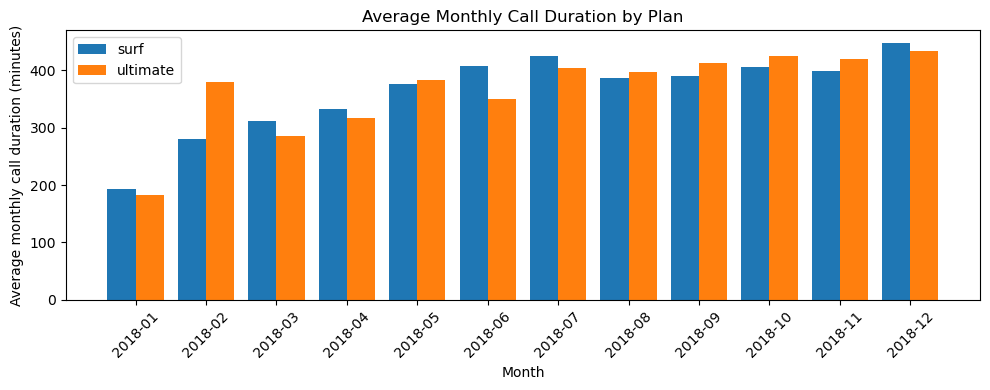

In [23]:
# Average monthly call duration by plan
avg_call_duration = (
    monthly_usage
    .groupby(["plan", "month"], as_index=False)["total_call_duration"]
    .mean()
)

# Convert Period to string for plotting
avg_call_duration["month_str"] = avg_call_duration["month"].astype(str)

plans = ["surf", "ultimate"]
months = sorted(avg_call_duration["month_str"].unique())

x = np.arange(len(months))
width = 0.40

plt.figure(figsize=(10, 4))

for i, plan in enumerate(plans):
    plan_values = (
        avg_call_duration.loc[avg_call_duration["plan"] == plan]
        .set_index("month_str")
        .reindex(months)["total_call_duration"]
        .values
    )
    plt.bar(x + i * width, plan_values, width, label=plan)

plt.xlabel("Month")
plt.ylabel("Average monthly call duration (minutes)")
plt.title("Average Monthly Call Duration by Plan")
plt.xticks(x + width / 2, months, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Descriptive statistics (by plan)
call_stats_by_plan = (
    monthly_usage
    .groupby("plan")["total_call_duration"]
    .agg(mean="mean", var="var", median="median", q1=lambda s: s.quantile(0.25), q3=lambda s: s.quantile(0.75))
    .round(2)
)

call_stats_by_plan

,mean,var,median,q1,q3
plan,,,,,
surf,404.76,49135.10,401.76,255.47,543.68
ultimate,406.19,51640.97,398.58,246.29,532.23


<Figure size 700x400 with 0 Axes>

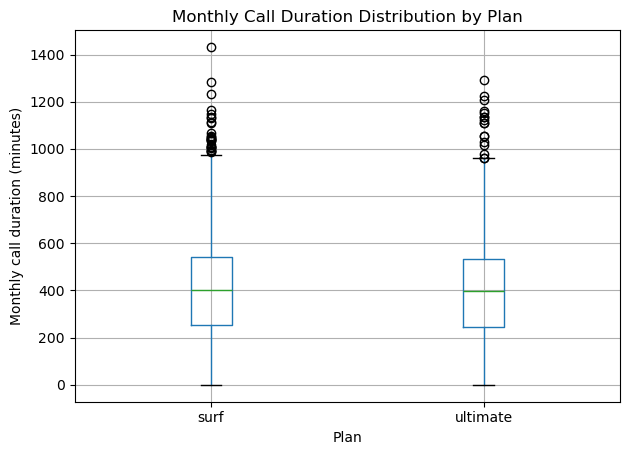

In [25]:
# Boxplot: distribution and outliers
plt.figure(figsize=(7, 4))

monthly_usage.boxplot(
    column="total_call_duration",
    by="plan"
)

plt.xlabel("Plan")
plt.ylabel("Monthly call duration (minutes)")
plt.title("Monthly Call Duration Distribution by Plan")
plt.suptitle("")
plt.tight_layout()
plt.show()

**Conclusions (Calls)** 
Call usage behavior is broadly similar between Surf and Ultimate customers. Both plans show comparable central tendency and spread, with right-skewed distributions and heavy-user outliers in both groups. This suggests that differences in revenue between plans are more likely driven by pricing structure and included allowances than by call behavior alone.

### Messaging Usage Patterns

This section analyzes messaging behavior by plan, focusing on monthly trends to assess whether message usage differs meaningfully between Surf and Ultimate subscribers and whether it contributes to revenue differences.

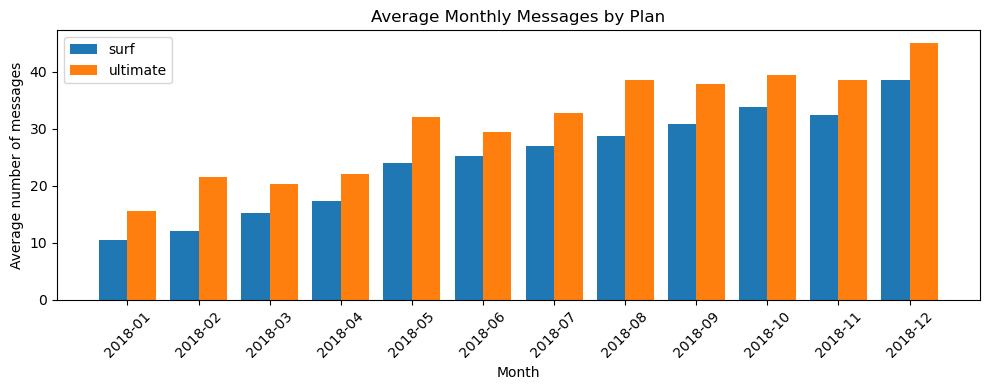

In [26]:
# Average monthly messages by plan
avg_messages = (
    monthly_usage
    .groupby(["plan", "month"], as_index=False)["message_count"]
    .mean()
)

# Convert Period to string for plotting
avg_messages["month_str"] = avg_messages["month"].astype(str)

plans = ["surf", "ultimate"]
months = sorted(avg_messages["month_str"].unique())

x = np.arange(len(months))
width = 0.40

plt.figure(figsize=(10, 4))

for i, plan in enumerate(plans):
    plan_values = (
        avg_messages.loc[avg_messages["plan"] == plan]
        .set_index("month_str")
        .reindex(months)["message_count"]
        .values
    )
    plt.bar(x + i * width, plan_values, width, label=plan)

plt.xlabel("Month")
plt.ylabel("Average number of messages")
plt.title("Average Monthly Messages by Plan")
plt.xticks(x + width / 2, months, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Conclusions (Messages)**  
Messaging behavior is highly similar between Surf and Ultimate customers across all months. While Ultimate users send slightly more messages on average, the difference is small and stable over time.

Overall, messaging usage does not represent a significant differentiator between plans and is unlikely to be a major driver of revenue differences compared to other usage dimensions.

### Internet Usage Patterns

This section analyzes internet consumption by plan, focusing on monthly trends and usage levels relative to plan allowances to assess their impact on overage charges and revenue.

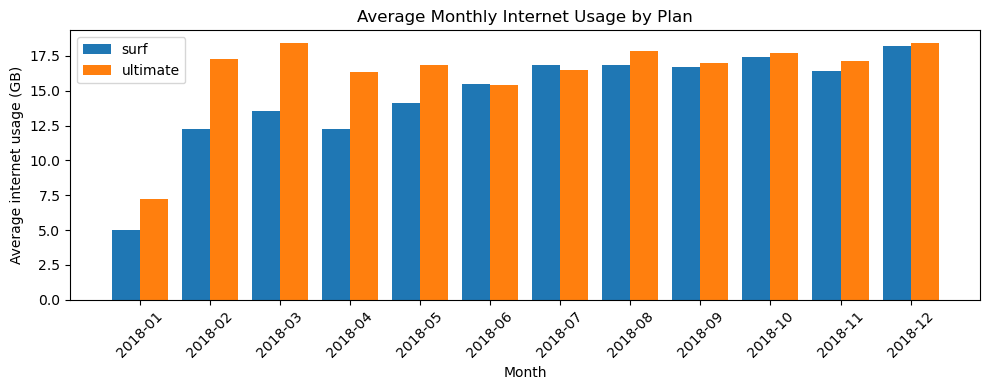

In [27]:
# Average monthly internet usage (GB) by plan
avg_internet = (
    monthly_usage
    .groupby(["plan", "month"], as_index=False)["gb_used"]
    .mean()
)

# Convert Period to string for plotting
avg_internet["month_str"] = avg_internet["month"].astype(str)

plans = ["surf", "ultimate"]
months = sorted(avg_internet["month_str"].unique())

x = np.arange(len(months))
width = 0.40

plt.figure(figsize=(10, 4))

for i, plan in enumerate(plans):
    plan_values = (
        avg_internet.loc[avg_internet["plan"] == plan]
        .set_index("month_str")
        .reindex(months)["gb_used"]
        .values
    )
    plt.bar(x + i * width, plan_values, width, label=plan)

plt.xlabel("Month")
plt.ylabel("Average internet usage (GB)")
plt.title("Average Monthly Internet Usage by Plan")
plt.xticks(x + width / 2, months, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Descriptive statistics of monthly internet usage by plan
internet_stats_by_plan = (
    monthly_usage
    .groupby("plan")["gb_used"]
    .agg(mean="mean", median="median", var="var")
    .round(2)
)

internet_stats_by_plan

,mean,median,var
plan,,,
surf,16.67,17.0,61.58
ultimate,17.31,17.0,58.83


**Conclusions (Internet)**  
Ultimate customers consistently consume more internet data than Surf customers across all months. While both plans exhibit a similar upward trend in usage over time, the absolute consumption level is higher for Ultimate subscribers.

Surf users frequently approach or exceed their included data allowance, increasing the likelihood of overage charges. In contrast, Ultimate users typically remain below their higher monthly limits, indicating that Surf customers are more exposed to variable charges driven by excess internet usage. This pattern suggests that internet overages are a key contributor to revenue differences between plans.

## Revenue Analysis

This section compares monthly revenue generated by Surf and Ultimate customers, focusing on central tendency, variability, and revenue stability over time.

In [29]:
# Descriptive statistics of monthly revenue by plan
revenue_stats_by_plan = (
    monthly_usage
    .groupby("plan")["monthly_revenue"]
    .agg(mean="mean", var="var", median="median")
    .round(2)
)

revenue_stats_by_plan

,mean,var,median
plan,,,
surf,60.33,3053.96,40.15
ultimate,72.31,129.85,70.00


<Figure size 700x400 with 0 Axes>

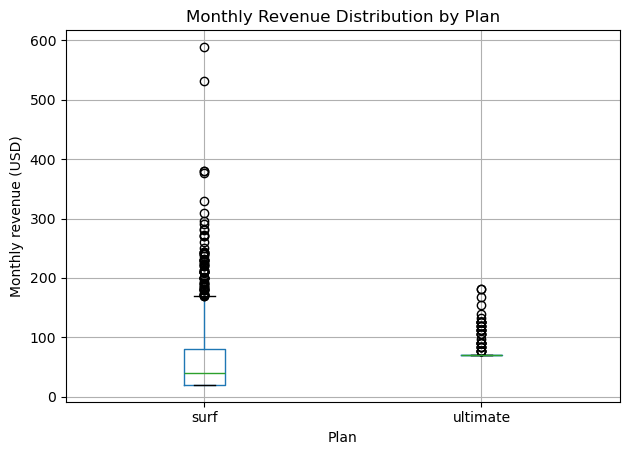

In [30]:
plt.figure(figsize=(7, 4))

monthly_usage.boxplot(
    column="monthly_revenue",
    by="plan"
)

plt.xlabel("Plan")
plt.ylabel("Monthly revenue (USD)")
plt.title("Monthly Revenue Distribution by Plan")
plt.suptitle("")
plt.tight_layout()
plt.show()

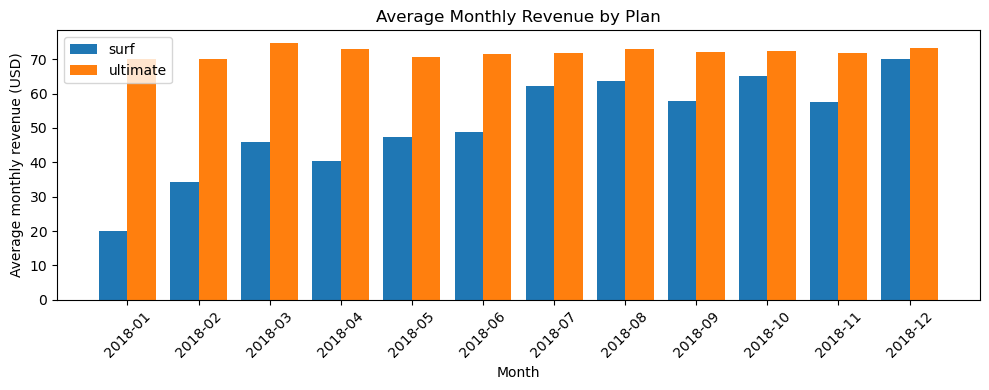

In [31]:
# Average monthly revenue by plan
avg_revenue = (
    monthly_usage
    .groupby(["plan", "month"], as_index=False)["monthly_revenue"]
    .mean()
)

# Convert Period to string for plotting
avg_revenue["month_str"] = avg_revenue["month"].astype(str)

plans = ["surf", "ultimate"]
months = sorted(avg_revenue["month_str"].unique())

x = np.arange(len(months))
width = 0.40

plt.figure(figsize=(10, 4))

for i, plan in enumerate(plans):
    plan_values = (
        avg_revenue.loc[avg_revenue["plan"] == plan]
        .set_index("month_str")
        .reindex(months)["monthly_revenue"]
        .values
    )
    plt.bar(x + i * width, plan_values, width, label=plan)

plt.xlabel("Month")
plt.ylabel("Average monthly revenue (USD)")
plt.title("Average Monthly Revenue by Plan")
plt.xticks(x + width / 2, months, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Conclusions (Revenue)**  
Ultimate customers generate higher and more stable monthly revenue on average compared to Surf customers. The substantially lower variance observed in the Ultimate plan indicates greater revenue predictability, driven primarily by the fixed monthly fee and higher included allowances.

In contrast, Surf revenue exhibits higher variability, with several high-revenue outliers resulting from overage charges. While this creates occasional revenue spikes, it also introduces volatility. Overall, Ultimate provides more consistent financial performance, whereas Surf offers higher upside potential at the cost of increased unpredictability.

## Hypothesis Testing

This section evaluates whether observed differences in revenue are statistically significant, using hypothesis testing to support data-driven conclusions.

### Test 1: Difference in Average Monthly Revenue Between Plans

- **Null hypothesis (H₀):** The average monthly revenue of Surf and Ultimate users is the same.  
- **Alternative hypothesis (H₁):** The average monthly revenue of Surf and Ultimate users is different.  
- **Significance level (α):** 0.05  

Welch’s t-test is used due to unequal variances between groups.

In [32]:
alpha = 0.05

revenue_surf = monthly_usage.loc[
    monthly_usage["plan"] == "surf", "monthly_revenue"
]

revenue_ultimate = monthly_usage.loc[
    monthly_usage["plan"] == "ultimate", "monthly_revenue"
]

t_stat, p_value = stats.ttest_ind(
    revenue_ultimate,
    revenue_surf,
    equal_var=False
)

t_stat, p_value

(np.float64(8.228840784742438), np.float64(3.5320199509520717e-16))

**Conclusion (Test 1)**  
The p-value is below the significance level, leading to rejection of the null hypothesis. This indicates a statistically significant difference in average monthly revenue between Surf and Ultimate users.

### Test 2: Difference in Average Monthly Revenue by Region (NY–NJ vs Others)

- **Null hypothesis (H₀):** The average monthly revenue in the NY–NJ region is equal to that of other regions.  
- **Alternative hypothesis (H₁):** The average monthly revenue in the NY–NJ region differs from other regions.  
- **Significance level (α):** 0.05  

Welch’s t-test is applied to account for unequal variances.

In [33]:
# Add city information
monthly_usage = monthly_usage.merge(
    megaline_users[["user_id", "city"]],
    on="user_id",
    how="left"
)

revenue_ny_nj = monthly_usage.loc[
    monthly_usage["city"].str.contains("NY-NJ", regex=False),
    "monthly_revenue"
]

revenue_other = monthly_usage.loc[
    ~monthly_usage["city"].str.contains("NY-NJ", regex=False),
    "monthly_revenue"
]

t_stat, p_value = stats.ttest_ind(
    revenue_ny_nj,
    revenue_other,
    equal_var=False
)

t_stat, p_value

(np.float64(-2.1597353056435127), np.float64(0.031214139070912725))

**Conclusion (Test 2)**  
The p-value is above the significance level, so the null hypothesis is not rejected. There is no statistically significant evidence that average monthly revenue differs between the NY–NJ region and other regions.

## Overall Conclusion

This project analyzed customer behavior and revenue generation for a telecommunications company offering two prepaid plans: Surf and Ultimate. The objective was to understand usage patterns, revenue dynamics, and determine which plan is more profitable and predictable from a business perspective.

The analysis began with data cleaning and preparation, including data type corrections, handling missing values in a business-consistent manner, and creating monthly aggregations per user. Call, messaging, and internet usage were consolidated into a single monthly dataset, enriched with plan information, and used to compute monthly revenue according to the pricing rules of each plan, including charges for exceeded limits.

Exploratory analysis showed that Surf and Ultimate users exhibit broadly similar behavior in terms of calls and messages, with right-skewed distributions and the presence of heavy users in both plans. Internet usage is slightly higher on average for Ultimate users, although variability is high across both plans. Notably, Surf users more frequently approach or exceed their data limits, while Ultimate users tend to remain below included thresholds.

Revenue analysis revealed clearer distinctions between plans. The Ultimate plan generates a higher and significantly more stable average monthly revenue, characterized by low variance and predictability. In contrast, the Surf plan shows high revenue variability, driven by a subset of users who generate substantial overage charges. This makes Surf more volatile, with occasional high-revenue users but less predictable overall performance.

Statistical hypothesis testing confirmed that the difference in average monthly revenue between Surf and Ultimate users is statistically significant at the 5% significance level. However, no statistically significant difference was found between the average revenue of users in the NY–NJ region and users from other regions.

Overall, the results indicate that plan structure has a stronger impact on revenue stability than basic usage behavior. While Surf users can generate high revenue through overages, the Ultimate plan offers greater financial predictability and consistency. These insights can support pricing strategy, customer segmentation, and revenue forecasting decisions.